# Pole Angle Detection Using Two Green Markers
## Wind Speed Estimation Project

This notebook detects two green markers on the pole and calculates the angle from vertical.

## 1. Setup and Imports

In [1]:
import numpy as np
import cv2
from picamera2 import Picamera2
import time
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Initialize Camera

In [2]:
# If camera is busy, run this cell first to release it
try:
    if 'picam2' in globals():
        picam2.stop()
        picam2.close()
        del picam2
        print("Previous camera instance released")
except:
    pass
print("Ready to initialize camera")

Ready to initialize camera


In [3]:
# Initialize camera
picam2 = Picamera2()
config = picam2.create_preview_configuration(
    main={"format": "RGB888", "size": (1280, 720)}
)
picam2.configure(config)
picam2.start()
time.sleep(0.5)

print("Camera initialized!")
print(f"Resolution: {config['main']['size']}")

[0:58:50.967217418] [10846]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[0:58:50.986370405] [10875]  INFO RPI pisp.cpp:720 libpisp version 1.3.0
[0:58:50.990971268] [10875]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/pisp/imx477.json
[0:58:50.998448830] [10875]  INFO Camera camera_manager.cpp:220 Adding camera '/base/axi/pcie@1000120000/rp1/i2c@80000/imx477@1a' for pipeline handler rpi/pisp
[0:58:50.998468515] [10875]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@80000/imx477@1a to CFE device /dev/media0 and ISP device /dev/media1 using PiSP variant BCM2712_C0
[0:58:51.007276908] [10846]  INFO Camera camera.cpp:1215 configuring streams: (0) 1280x720-RGB888/sRGB (1) 2028x1080-BGGR_PISP_COMP1/RAW
[0:58:51.007444722] [10875]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@80000/imx477@1a - Selected sensor format: 2028x1080-SBGGR12_1X12/RAW - Selected CFE format: 2028x1080-PC1B/RAW


Camera initialized!
Resolution: (1280, 720)


## 2.5 Load Camera Calibration (Optional)

Load lens distortion calibration if available. Run `calibration/calibrate.py` first to generate the config.

In [4]:
import json
import os

# Calibration config path
CALIBRATION_CONFIG_PATH = os.path.join(os.path.dirname(os.path.abspath(".")), 
                                        "CW_Solution", "calibration", "camera_config.json")

# Try relative path first (when running from CW_Solution directory)
if not os.path.exists(CALIBRATION_CONFIG_PATH):
    CALIBRATION_CONFIG_PATH = "calibration/camera_config.json"

def load_calibration():
    """Load camera calibration from config file and create undistortion maps."""
    if not os.path.exists(CALIBRATION_CONFIG_PATH):
        print(f"[!] No calibration found at: {CALIBRATION_CONFIG_PATH}")
        print("    Run 'python calibration/calibrate.py' first to calibrate the camera.")
        print("    Continuing without lens distortion correction...")
        return None, None
    
    try:
        with open(CALIBRATION_CONFIG_PATH, 'r') as f:
            config = json.load(f)
        
        # Reconstruct camera matrix and distortion coefficients
        camera_matrix = np.array(config["camera_matrix"])
        dist_coeffs = np.array(config["distortion_coefficients"])
        image_size = tuple(config["image_size"])
        
        # Pre-compute undistortion maps for fast remapping
        map1, map2 = cv2.initUndistortRectifyMap(
            camera_matrix, dist_coeffs, None, camera_matrix,
            image_size, cv2.CV_16SC2
        )
        
        print(f"[*] Calibration loaded successfully!")
        print(f"    Reprojection error: {config.get('reprojection_error', 'N/A'):.4f} pixels")
        print(f"    Calibrated for resolution: {image_size[0]}x{image_size[1]}")
        return map1, map2
        
    except Exception as e:
        print(f"[!] Error loading calibration: {e}")
        print("    Continuing without lens distortion correction...")
        return None, None

def undistort_frame(frame, map1, map2):
    """Apply lens distortion correction to a frame."""
    return cv2.remap(frame, map1, map2, cv2.INTER_LINEAR)

# Load calibration
undistort_map1, undistort_map2 = load_calibration()
calibration_enabled = undistort_map1 is not None

print(f"\nCalibration enabled: {calibration_enabled}")

[*] Calibration loaded successfully!
    Reprojection error: 0.1363 pixels
    Calibrated for resolution: 1280x720

Calibration enabled: True


## 3. Configure Detection Parameters

In [5]:
# Green marker HSV thresholds (adjust these for your setup)
lower_green = np.array([35, 50, 50])
upper_green = np.array([85, 255, 255])

# Minimum contour area for green detection
min_area = 100

print("Detection parameters configured")

Detection parameters configured


## 4. Test Detection on Single Frame

Applied lens distortion correction
Found 0 markers (need exactly 2)


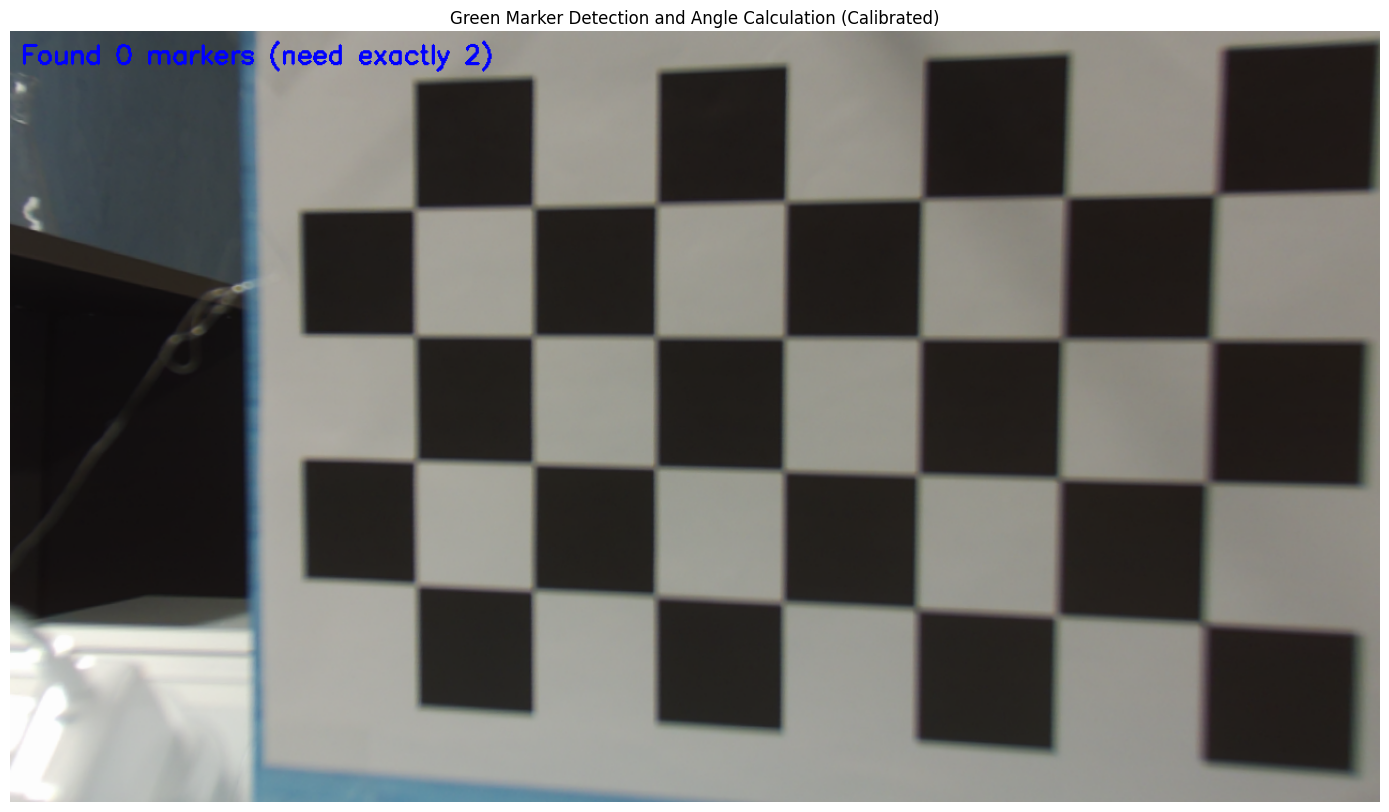

In [6]:
# Capture a test frame
frame = picam2.capture_array()

# Apply lens distortion correction if calibration is available
if calibration_enabled:
    frame = undistort_frame(frame, undistort_map1, undistort_map2)
    print("Applied lens distortion correction")

# Green detection
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
mask_green = cv2.inRange(hsv, lower_green, upper_green)

# Clean mask
kernel = np.ones((5, 5), np.uint8)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Get centroids
centroids = []
for cnt in valid_contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroids.append((cx, cy))

# Visualize
display_frame = frame.copy()
for i, (cx, cy) in enumerate(centroids):
    cv2.circle(display_frame, (cx, cy), 10, (255, 0, 0), -1)
    cv2.putText(display_frame, f"Marker {i+1}", (cx + 15, cy - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# If we have exactly 2 markers, draw line and calculate angle
if len(centroids) == 2:
    p1, p2 = centroids[0], centroids[1]
    
    # Draw line between markers
    cv2.line(display_frame, p1, p2, (0, 255, 0), 3)
    
    # Calculate angle from vertical
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    # Angle from horizontal (in radians)
    angle_rad_horizontal = np.arctan2(dy, dx)
    
    # Angle from vertical (0 = hanging straight down, π/2 = horizontal)
    # Vertical down is when dy is positive and dx is 0, which gives π/2 from horizontal
    # So: angle_from_vertical = |π/2 - angle_from_horizontal|
    angle_from_vertical = abs(np.pi/2 - angle_rad_horizontal)
    
    angle_deg = np.degrees(angle_from_vertical)
    
    # Display angle
    mid_x = (p1[0] + p2[0]) // 2
    mid_y = (p1[1] + p2[1]) // 2
    
    angle_text = f"Angle: {angle_from_vertical:.3f} rad ({angle_deg:.1f} deg)"
    cv2.putText(display_frame, angle_text, (mid_x + 20, mid_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
    
    print(f"\n=== Angle Calculation ===")
    print(f"Marker 1: {p1}")
    print(f"Marker 2: {p2}")
    print(f"Angle from vertical: {angle_from_vertical:.4f} radians ({angle_deg:.2f} degrees)")
    print(f"Range: 0 rad (vertical) to π/2 rad (horizontal)")
else:
    cv2.putText(display_frame, f"Found {len(centroids)} markers (need exactly 2)", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    print(f"Found {len(centroids)} markers (need exactly 2)")

# Display result
plt.figure(figsize=(14, 10))
plt.imshow(display_frame)
title = "Green Marker Detection and Angle Calculation"
if calibration_enabled:
    title += " (Calibrated)"
plt.title(title)
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Live Angle Detection with Recording

**Real-time angle measurement with video recording and live plot**

Click the stop button (■) to interrupt

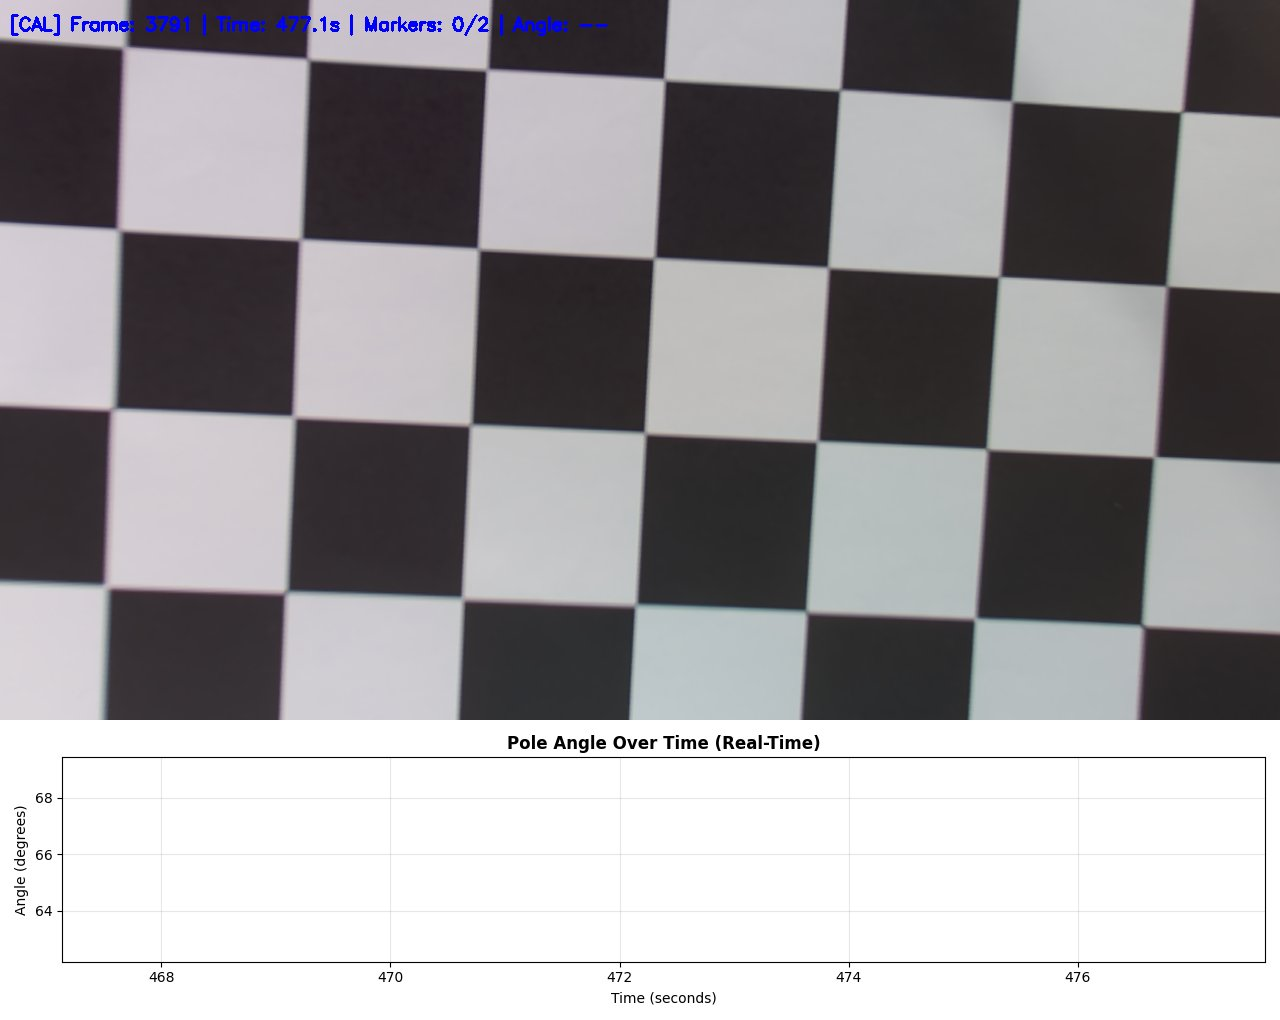


Live preview stopped by user

Total frames captured: 3792
Actual duration: 477.32 seconds
Effective FPS: 7.9
Video saved to: output/20251202_151820/video.mp4

Angle Statistics:
  Average: 65.81°
  Min: 65.81°
  Max: 65.81°
  Std Dev: 0.00°
  Angle data saved to: output/20251202_151820/angle_data.csv


: 

In [ ]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

print("Starting live angle detection with recording... Press STOP button to interrupt")
if calibration_enabled:
    print("Lens distortion correction: ENABLED")
else:
    print("Lens distortion correction: DISABLED (run calibration/calibrate.py to enable)")
print("")

# Create output directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"output/{timestamp}"
os.makedirs(output_dir, exist_ok=True)
video_path = os.path.join(output_dir, "video.mp4")

print(f"Recording to: {video_path}")
print("")

# Video writer setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
frame_size = (1280, 720 + 300)  # Video height + plot height
video_writer = cv2.VideoWriter(video_path, fourcc, fps, frame_size)

try:
    frame_count = 0
    angle_history = []
    time_history = []  # Actual elapsed time for each measurement
    
    # Pre-create kernel for reuse
    kernel = np.ones((5, 5), np.uint8)
    
    # Create matplotlib figure for angle plot
    fig, ax = plt.subplots(figsize=(12.8, 3))
    fig.patch.set_facecolor('white')
    
    # Track actual time
    recording_start_time = time.time()
    last_video_time = 0.0  # Track video timeline (at constant fps)
    frame_duration = 1.0 / fps  # Duration of each video frame
    
    while True:
        loop_start = time.time()
        actual_elapsed = loop_start - recording_start_time
        
        # Capture frame
        frame = picam2.capture_array()
        
        # Apply lens distortion correction if calibration is available
        if calibration_enabled:
            frame = undistort_frame(frame, undistort_map1, undistort_map2)
        
        # Green detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        
        # Single morph operation (faster)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
        
        # Find contours and centroids
        contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        centroids = []
        for cnt in contours:
            if cv2.contourArea(cnt) > min_area:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append((cx, cy))
                    
                    # Draw marker (simple)
                    cv2.circle(frame, (cx, cy), 8, (255, 0, 0), -1)
        
        # Calculate angle if we have exactly 2 markers
        angle_text = "--"
        status_color = (0, 0, 255)  # Red by default
        current_angle = None
        
        if len(centroids) == 2:
            p1, p2 = centroids[0], centroids[1]
            
            # Draw line between markers
            cv2.line(frame, p1, p2, (0, 255, 0), 2)
            
            # Calculate angle from vertical
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            
            angle_rad_horizontal = np.arctan2(dy, dx)
            angle_from_vertical = abs(np.pi/2 - angle_rad_horizontal)
            
            # Convert to degrees and subtract 180
            angle_deg = np.degrees(angle_from_vertical) - 180
            
            # Store angle with ACTUAL timestamp
            current_angle = angle_deg
            angle_history.append(angle_deg)
            time_history.append(actual_elapsed)
            
            # Keep last 10 seconds of data based on actual time
            while time_history and (actual_elapsed - time_history[0]) > 10.0:
                angle_history.pop(0)
                time_history.pop(0)
            
            angle_text = f"{angle_deg:.1f}°"
            status_color = (0, 255, 0)  # Green when tracking
            
            # Display angle at midpoint
            mid_x = (p1[0] + p2[0]) // 2
            mid_y = (p1[1] + p2[1]) // 2
            cv2.putText(frame, angle_text, (mid_x + 20, mid_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Display status overlay with actual time
        cal_status = "[CAL]" if calibration_enabled else "[UNCAL]"
        status_text = f"{cal_status} Frame: {frame_count} | Time: {actual_elapsed:.1f}s | Markers: {len(centroids)}/2 | Angle: {angle_text}"
        cv2.putText(frame, status_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, status_color, 2)
        
        # Create angle plot using ACTUAL timestamps
        ax.clear()
        if len(angle_history) > 0:
            ax.plot(time_history, angle_history, 'b-', linewidth=2)
            if current_angle is not None:
                ax.plot(time_history[-1], current_angle, 'ro', markersize=8)
            ax.set_xlabel('Time (seconds)', fontsize=10)
            ax.set_ylabel('Angle (degrees)', fontsize=10)
            ax.set_title('Pole Angle Over Time (Real-Time)', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(max(0, actual_elapsed - 10), actual_elapsed + 0.5)  # Show last 10 seconds
            
            # Add current value text
            if current_angle is not None:
                ax.text(0.02, 0.98, f'Current: {current_angle:.1f}°', 
                       transform=ax.transAxes, fontsize=12, fontweight='bold',
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'Waiting for angle data...', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=14)
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Angle (degrees)')
        
        fig.tight_layout()
        
        # Convert plot to image
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        plot_image = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
        plot_image = plot_image.reshape(canvas.get_width_height()[::-1] + (4,))
        plot_image = cv2.cvtColor(plot_image, cv2.COLOR_RGBA2RGB)
        plot_image = cv2.resize(plot_image, (1280, 300))
        
        # Combine video frame and plot
        combined_frame = np.vstack([frame, plot_image])
        combined_frame_bgr = cv2.cvtColor(combined_frame, cv2.COLOR_RGB2BGR)
        
        # Write frames to maintain real-time sync
        # Calculate how many frames we need to write to keep video in sync with actual time
        while last_video_time < actual_elapsed:
            video_writer.write(combined_frame_bgr)
            last_video_time += frame_duration
        
        # Encode and display (lower quality for speed)
        _, buffer = cv2.imencode('.jpg', combined_frame_bgr, [cv2.IMWRITE_JPEG_QUALITY, 85])
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))
        
        frame_count += 1
        
        # Small sleep to prevent CPU overload, but don't try to maintain fixed fps
        time.sleep(0.001)
        
except KeyboardInterrupt:
    print("\nLive preview stopped by user")
finally:
    # Release video writer
    video_writer.release()
    plt.close(fig)
    
    actual_duration = time.time() - recording_start_time
    print(f"\nTotal frames captured: {frame_count}")
    print(f"Actual duration: {actual_duration:.2f} seconds")
    print(f"Effective FPS: {frame_count / actual_duration:.1f}")
    print(f"Video saved to: {video_path}")
    
    if angle_history:
        avg_angle = np.mean(angle_history)
        print(f"\nAngle Statistics:")
        print(f"  Average: {avg_angle:.2f}°")
        print(f"  Min: {np.min(angle_history):.2f}°")
        print(f"  Max: {np.max(angle_history):.2f}°")
        print(f"  Std Dev: {np.std(angle_history):.2f}°")
        
        # Save angle data to CSV with ACTUAL timestamps
        csv_path = os.path.join(output_dir, "angle_data.csv")
        with open(csv_path, 'w') as f:
            f.write("time_seconds,angle_degrees\n")
            for t, a in zip(time_history, angle_history):
                f.write(f"{t:.3f},{a:.2f}\n")
        print(f"  Angle data saved to: {csv_path}")

## 6. Adjust HSV Thresholds (If Needed)

In [ ]:
# Adjust these values if green markers aren't detected properly
H_min, S_min, V_min = 35, 50, 50      # Lower bounds
H_max, S_max, V_max = 85, 255, 255    # Upper bounds

lower_green = np.array([H_min, S_min, V_min])
upper_green = np.array([H_max, S_max, V_max])

print(f"Updated HSV range:")
print(f"  Lower: {lower_green}")
print(f"  Upper: {upper_green}")
print("\nRe-run section 4 or 5 to test new thresholds")

: 

## 7. Adjust Minimum Area (If Needed)

In [ ]:
# Increase this to filter out smaller noise
# Decrease if markers are too small to be detected
min_area = 100

print(f"Minimum contour area set to: {min_area} pixels")
print("Re-run section 4 or 5 to test")

: 

## 8. Save Configuration

In [ ]:
import json

config_data = {
    "hsv_lower_green": lower_green.tolist(),
    "hsv_upper_green": upper_green.tolist(),
    "min_contour_area": min_area,
    "camera_resolution": config['main']['size'],
    "description": "Two-marker pole angle detection for wind speed estimation"
}

with open('angle_detection_config.json', 'w') as f:
    json.dump(config_data, f, indent=2)

print("Configuration saved to angle_detection_config.json")
print(json.dumps(config_data, indent=2))

: 

## 9. Stop Camera

In [ ]:
picam2.stop()
print("Camera stopped")

Camera stopped


: 

: 